In [2]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

In [36]:
FIRST_CONDITION = 250
SECOND_CONDITION = 200
THIRD_CONDITION =  150
FOURTH_CONDITION = 100
FIFTH_CONDITION = 50

## helper function to load and parse annotations

In [3]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [4]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [5]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(condition)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

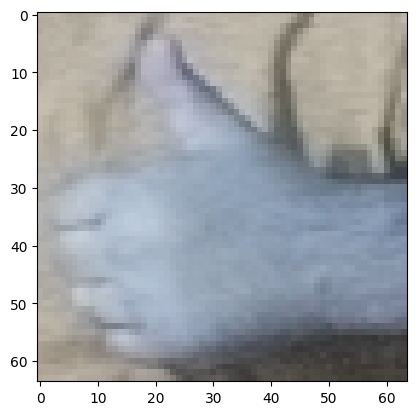

In [6]:
plt.imshow(random.sample(images, 1)[0])

In [33]:
def train_model(dataset_size):

    # https://stackoverflow.com/questions/61550026/valueerror-shapes-none-1-and-none-3-are-incompatible

    X_train, X_test, y_train, y_test = train_test_split(images[:dataset_size], labels[:dataset_size], test_size=0.2, random_state=42)

    # training and test data
    print(len(X_train))
    print(len(X_test))
    print(len(y_train))
    print(len(y_test))

    X_train = np.array(X_train).astype('float32')
    X_train = X_train / 255.

    X_test = np.array(X_test).astype('float32')
    X_test = X_test / 255.

    y_train_one_hot = to_categorical(y_train, 3)
    y_test_one_hot = to_categorical(y_test, 3)

    train_label = y_train_one_hot
    test_label = y_test_one_hot

    X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
    X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

    # transformed data
    print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

    # variables for hyperparameters
    batch_size = 8
    epochs = 50
    num_classes = len(label_names)
    activation = 'relu'
    activation_conv = 'LeakyReLU'  # LeakyReLU
    layer_count = 2
    num_neurons = 64

    # define model structure
    # with keras, we can use a model's add() function to add layers to the network one by one
    model = Sequential()

    # data augmentation (this can also be done beforehand - but don't augment the test dataset!)
    model.add(RandomFlip('horizontal'))
    model.add(RandomContrast(0.1))
    #model.add(RandomBrightness(0.1))
    #model.add(RandomRotation(0.2))

    # first, we add some convolution layers followed by max pooling
    model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

    model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # dropout layers can drop part of the data during each epoch - this prevents overfitting
    model.add(Dropout(0.2))

    # after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
    model.add(Flatten())

    # add some fully connected layers ("Dense")
    for i in range(layer_count - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(num_neurons, activation=activation))

    # for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
    model.add(Dense(num_classes, activation='softmax'))

    # specify loss function, optimizer and evaluation metrics
    # for classification, categorial crossentropy is used as a loss function
    # use the adam optimizer unless you have a good reason not to
    model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

    # define callback functions that react to the model's behavior during training
    # in this example, we reduce the learning rate once we get stuck and early stopping
    # to cancel the training if there are no improvements for a certain amount of epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(
        X_train,
        train_label,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, test_label),
        callbacks=[reduce_lr, stop_early]
    )

    return history, model



## Plot accuracy and loss of the training process

In [34]:
def show_training_results(history, model):

    model.summary()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)

# FIRST CONDITION 250

In [37]:
history, model = train_model(FIRST_CONDITION)

200
50
200
50
(200, 64, 64, 3) (50, 64, 64, 3) (200, 3) (50, 3)
Epoch 1/50
25/25 [==============================] - 2s 41ms/step - loss: 0.6148 - accuracy: 0.7450 - val_loss: 0.5920 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 1s 38ms/step - loss: 0.5024 - accuracy: 0.7700 - val_loss: 0.5753 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 3/50
25/25 [==============================] - 1s 37ms/step - loss: 0.4873 - accuracy: 0.7550 - val_loss: 0.5428 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 4/50
25/25 [==============================] - 1s 37ms/step - loss: 0.5278 - accuracy: 0.7750 - val_loss: 0.5204 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 5/50
25/25 [==============================] - 1s 37ms/step - loss: 0.4909 - accuracy: 0.8150 - val_loss: 0.5448 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 6/50
25/25 [==============================] - 1s 36ms/step - loss: 0.3652 - accuracy: 0.8100 - val_loss: 0.5371 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 7/50
2

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_11 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_contrast_11 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_33 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 6, 6, 32)       

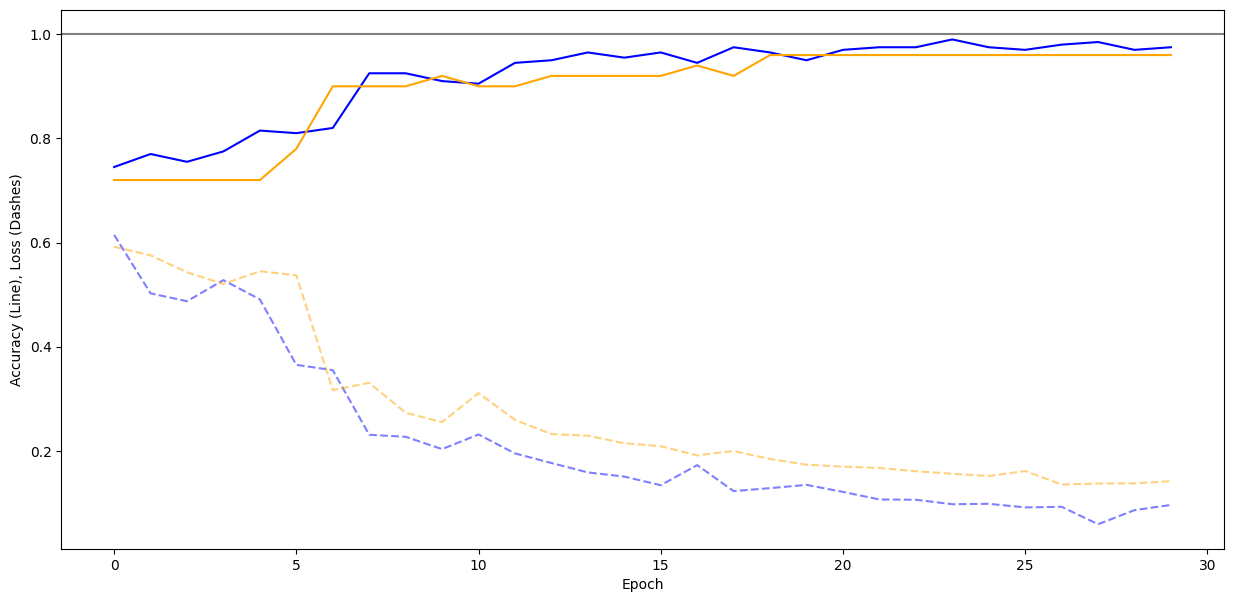

In [38]:
show_training_results(history, model)

# SECOND CONDITION 200

In [39]:
history, model = train_model(SECOND_CONDITION)

160
40
160
40
(160, 64, 64, 3) (40, 64, 64, 3) (160, 3) (40, 3)
Epoch 1/50
20/20 [==============================] - 3s 42ms/step - loss: 0.6513 - accuracy: 0.7563 - val_loss: 0.5250 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 1s 37ms/step - loss: 0.5615 - accuracy: 0.7437 - val_loss: 0.4364 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 1s 37ms/step - loss: 0.5686 - accuracy: 0.7563 - val_loss: 0.5157 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 1s 37ms/step - loss: 0.4791 - accuracy: 0.7750 - val_loss: 0.4462 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 1s 37ms/step - loss: 0.4590 - accuracy: 0.7688 - val_loss: 0.3933 - val_accuracy: 0.8000 - lr: 2.0000e-04
Epoch 6/50
20/20 [==============================] - 1s 37ms/step - loss: 0.4348 - accuracy: 0.7688 - val_loss: 0.3814 - val_accuracy: 0.8000 - lr: 2.0000e-04
Epoc

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_12 (RandomFlip)  (8, 64, 64, 3)           0         
                                                                 
 random_contrast_12 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_36 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 6, 6, 32)       

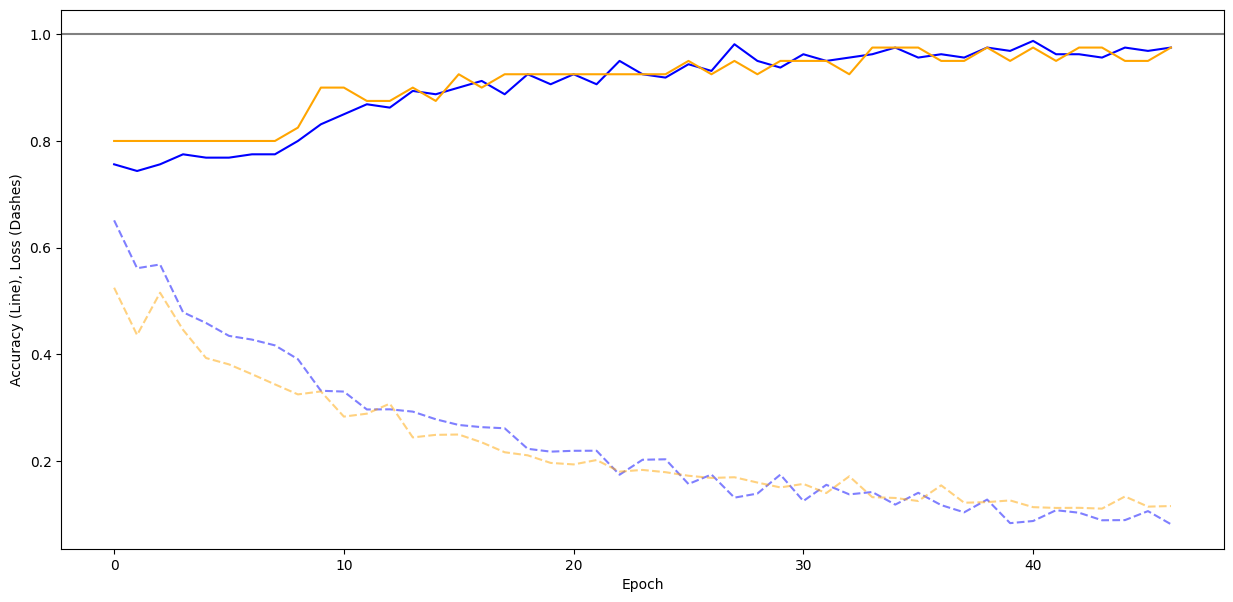

In [40]:
show_training_results(history, model)

# THIRD CONDITION 150

In [41]:
history, model = train_model(THIRD_CONDITION)

120
30
120
30
(120, 64, 64, 3) (30, 64, 64, 3) (120, 3) (30, 3)
Epoch 1/50
15/15 [==============================] - 2s 45ms/step - loss: 0.9252 - accuracy: 0.7083 - val_loss: 0.7360 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 1s 38ms/step - loss: 0.6004 - accuracy: 0.7417 - val_loss: 0.5806 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 1s 38ms/step - loss: 0.5732 - accuracy: 0.7500 - val_loss: 0.6130 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 1s 38ms/step - loss: 0.5343 - accuracy: 0.7500 - val_loss: 0.4419 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 1s 38ms/step - loss: 0.5054 - accuracy: 0.7500 - val_loss: 0.4321 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 1s 37ms/step - loss: 0.5105 - accuracy: 0.7500 - val_loss: 0.4432 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 7/50
1

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_13 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_contrast_13 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 6, 6, 32)       

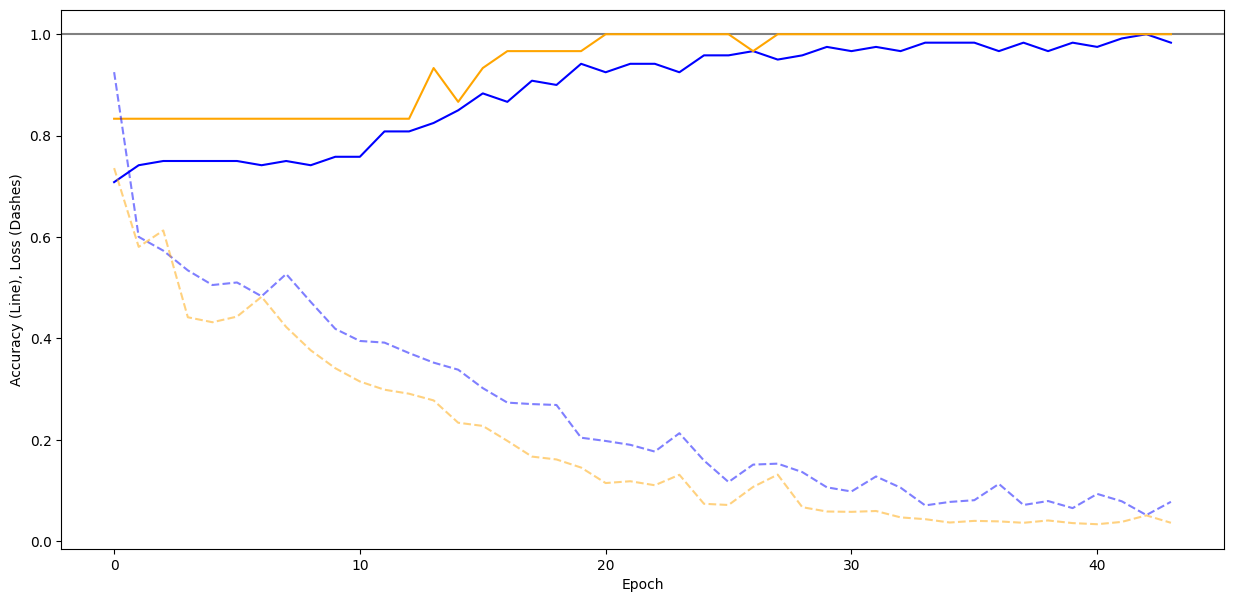

In [42]:
show_training_results(history, model)

# FOURTH CONDITION 100

In [43]:
history, model = train_model(FOURTH_CONDITION)

80
20
80
20
(80, 64, 64, 3) (20, 64, 64, 3) (80, 3) (20, 3)
Epoch 1/50
10/10 [==============================] - 2s 51ms/step - loss: 0.7416 - accuracy: 0.7250 - val_loss: 0.3557 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 0s 39ms/step - loss: 0.5532 - accuracy: 0.7375 - val_loss: 0.6723 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 0s 38ms/step - loss: 0.5597 - accuracy: 0.7250 - val_loss: 0.2906 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 0s 38ms/step - loss: 0.5816 - accuracy: 0.7500 - val_loss: 0.6175 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 0s 38ms/step - loss: 0.5853 - accuracy: 0.7250 - val_loss: 0.3837 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 0s 37ms/step - loss: 0.4860 - accuracy: 0.7250 - val_loss: 0.3147 - val_accuracy: 0.9500 - lr: 2.0000e-04


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_14 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_contrast_14 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 6, 6, 32)       

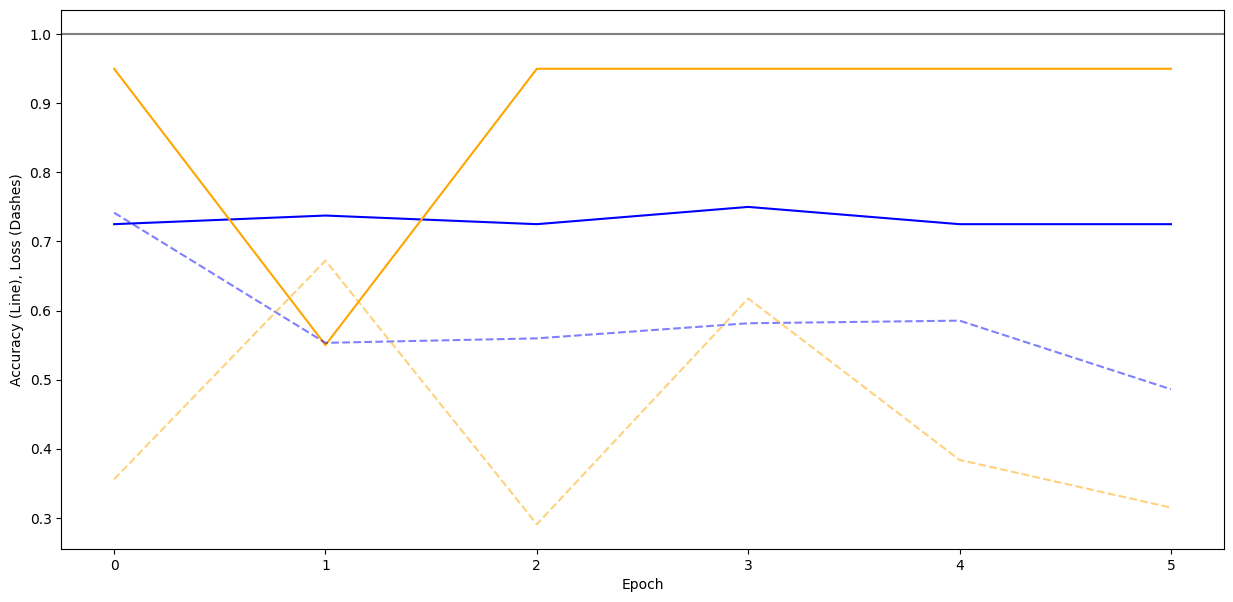

In [44]:
show_training_results(history, model)

# FIFTH CONDITION 50

In [45]:
history, model = train_model(FIFTH_CONDITION)

40
10
40
10
(40, 64, 64, 3) (10, 64, 64, 3) (40, 3) (10, 3)
Epoch 1/50
5/5 [==============================] - 2s 70ms/step - loss: 1.1151 - accuracy: 0.2500 - val_loss: 0.9695 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/50
5/5 [==============================] - 0s 40ms/step - loss: 0.9744 - accuracy: 0.7500 - val_loss: 0.4935 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/50
5/5 [==============================] - 0s 40ms/step - loss: 0.6467 - accuracy: 0.7500 - val_loss: 0.4540 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/50
5/5 [==============================] - 0s 41ms/step - loss: 0.6018 - accuracy: 0.7500 - val_loss: 0.4460 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/50
5/5 [==============================] - 0s 40ms/step - loss: 0.5833 - accuracy: 0.7250 - val_loss: 0.5000 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 6/50
5/5 [==============================] - 0s 44ms/step - loss: 0.6592 - accuracy: 0.7000 - val_loss: 0.4342 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 7/50
5/5 [============

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_15 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_contrast_15 (RandomC  (None, 64, 64, 3)        0         
 ontrast)                                                        
                                                                 
 conv2d_45 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 6, 6, 32)       

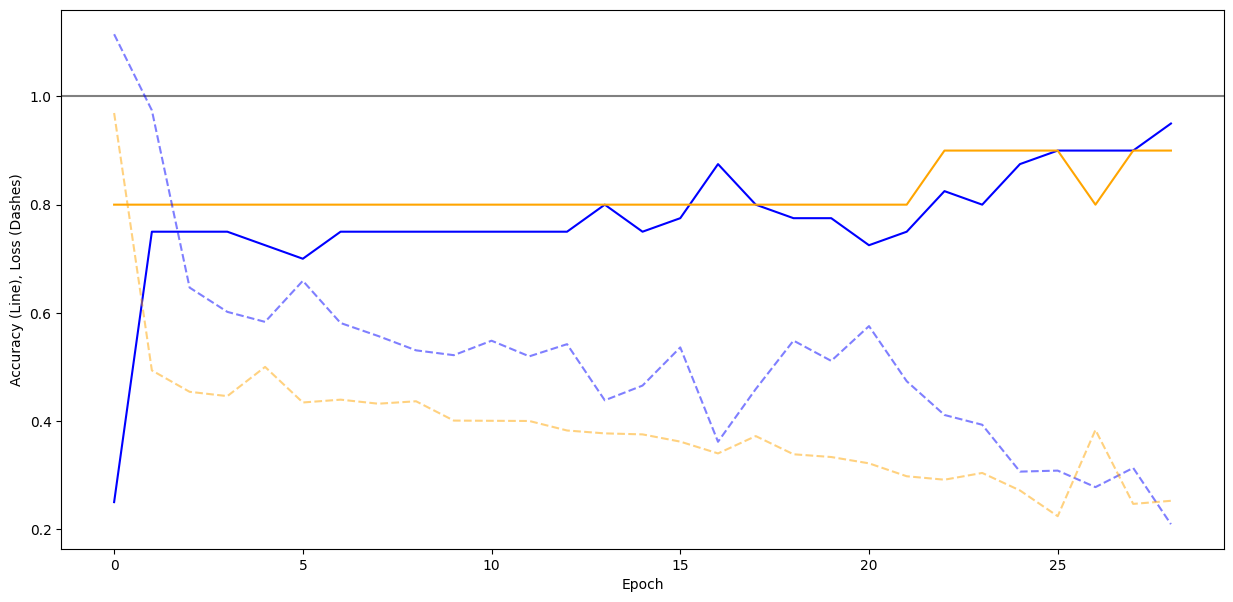

In [46]:
show_training_results(history, model)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [ ]:
model.save('gesture_recognition')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

In [ ]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

## let's test our model in action

In [ ]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if COLOR_CHANNELS == 1:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
cap.release()
plt.imshow(frame)

## manual cropping for demonstration purposes - you can do better!

In [ ]:
plt.imshow(frame[50:350, 60:210])

In [ ]:
resized = cv2.resize(frame[50:350, 60:210], SIZE)#[20:350, 200:420], SIZE)
plt.imshow(resized)
resized.shape

In [ ]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape
prediction = model.predict(reshaped)

print(label_names[np.argmax(prediction)], np.max(prediction))

In [ ]:
filters, biases = model.layers[2].get_weights()
print(filters.shape)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        img = filters[:,:,:,i*8+j]
        axes[i][j].imshow(img)

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        #axes[i][j].imshow(filters[:,:,:,i*8+j] * 255, 'gray')
        kernel = filters[:,:,0,i*8+j]

        #print(kernel.shape)

        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        filtered = cv2.filter2D(gray, -1, kernel)

        axes[i][j].imshow(filtered, 'gray')

## Transfer Learning

let's use a pre-trained model (VGG16) for our prediction

note that VGG16 needs three color channels

In [ ]:
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 256

# load a VGG16 model trained on the imagenet dataset
# include_top=False -> do not include the output layer
# input_tensor -> tells the model about the dimensions of our images (VGG16 needs three color channels)
# pooling -> which type of pooling to use between convolutions; max or avg seem to be the best
VGG = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)), pooling='max')

# we want to use the VGG's original weights -> make those layers untrainable
for layer in VGG.layers:
    layer.trainable = False

# build a new model and add the VGG layers
model_vgg = Sequential()
model_vgg.add(VGG)

# append dense layers at the end
for i in range(layer_count - 1):
    model_vgg.add(Dense(num_neurons, activation=activation))
model_vgg.add(Dropout(0.2))

model_vgg.add(Dense(num_neurons, activation=activation))

# classifier
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history_vgg = model_vgg.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

In [ ]:
model_vgg.summary()

In [ ]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [ ]:
# let the model make predictions for our training data
y_predictions = model_vgg.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass